# Proyek Klasifikasi Gambar: Animals-10
- **Nama:** Andrew Jonatan Damanik
- **Email:** andrewdamanik23@gmail.com
- **ID Dicoding:** drewjd27

# About
Melakukan pelatihan model MobileNet untuk melakukan klasifikasi gambar hewan dengan 10 kelas.

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install split-folders

In [2]:
!pip install -q tensorflow

In [3]:
!pip install -q tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [4]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import splitfolders

import kagglehub
from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Libraries untuk pemrosesan data gambar
import cv2
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-04-21 01:33:16.841460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745199197.154862      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745199197.231394      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


In [6]:
!nvidia-smi

Mon Apr 21 01:33:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

I0000 00:00:1745199224.563064      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745199224.563727      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
print(f"Number of GPUs Available: {strategy.num_replicas_in_sync}")

Number of GPUs Available: 2


In [9]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Data Preparation

### Data Loading

In [10]:
# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


In [11]:
ds_dir = '/kaggle/input/animals10/raw-img'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CHANNELS = 3

In [12]:
#menghitung jumlah sampel data
def count_images(directory, extensions=('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
    total_img = 0
    # os.walk traverses all subdirectories
    for root, dirs, files in os.walk(directory):
        # Filter files that match common image extensions
        img_files = [file for file in files if file.lower().endswith(extensions)]
        total_img += len(img_files)
    return total_img

total = count_images(ds_dir)
print("Total gambar pada dataset:", total)

Total gambar pada dataset: 26179


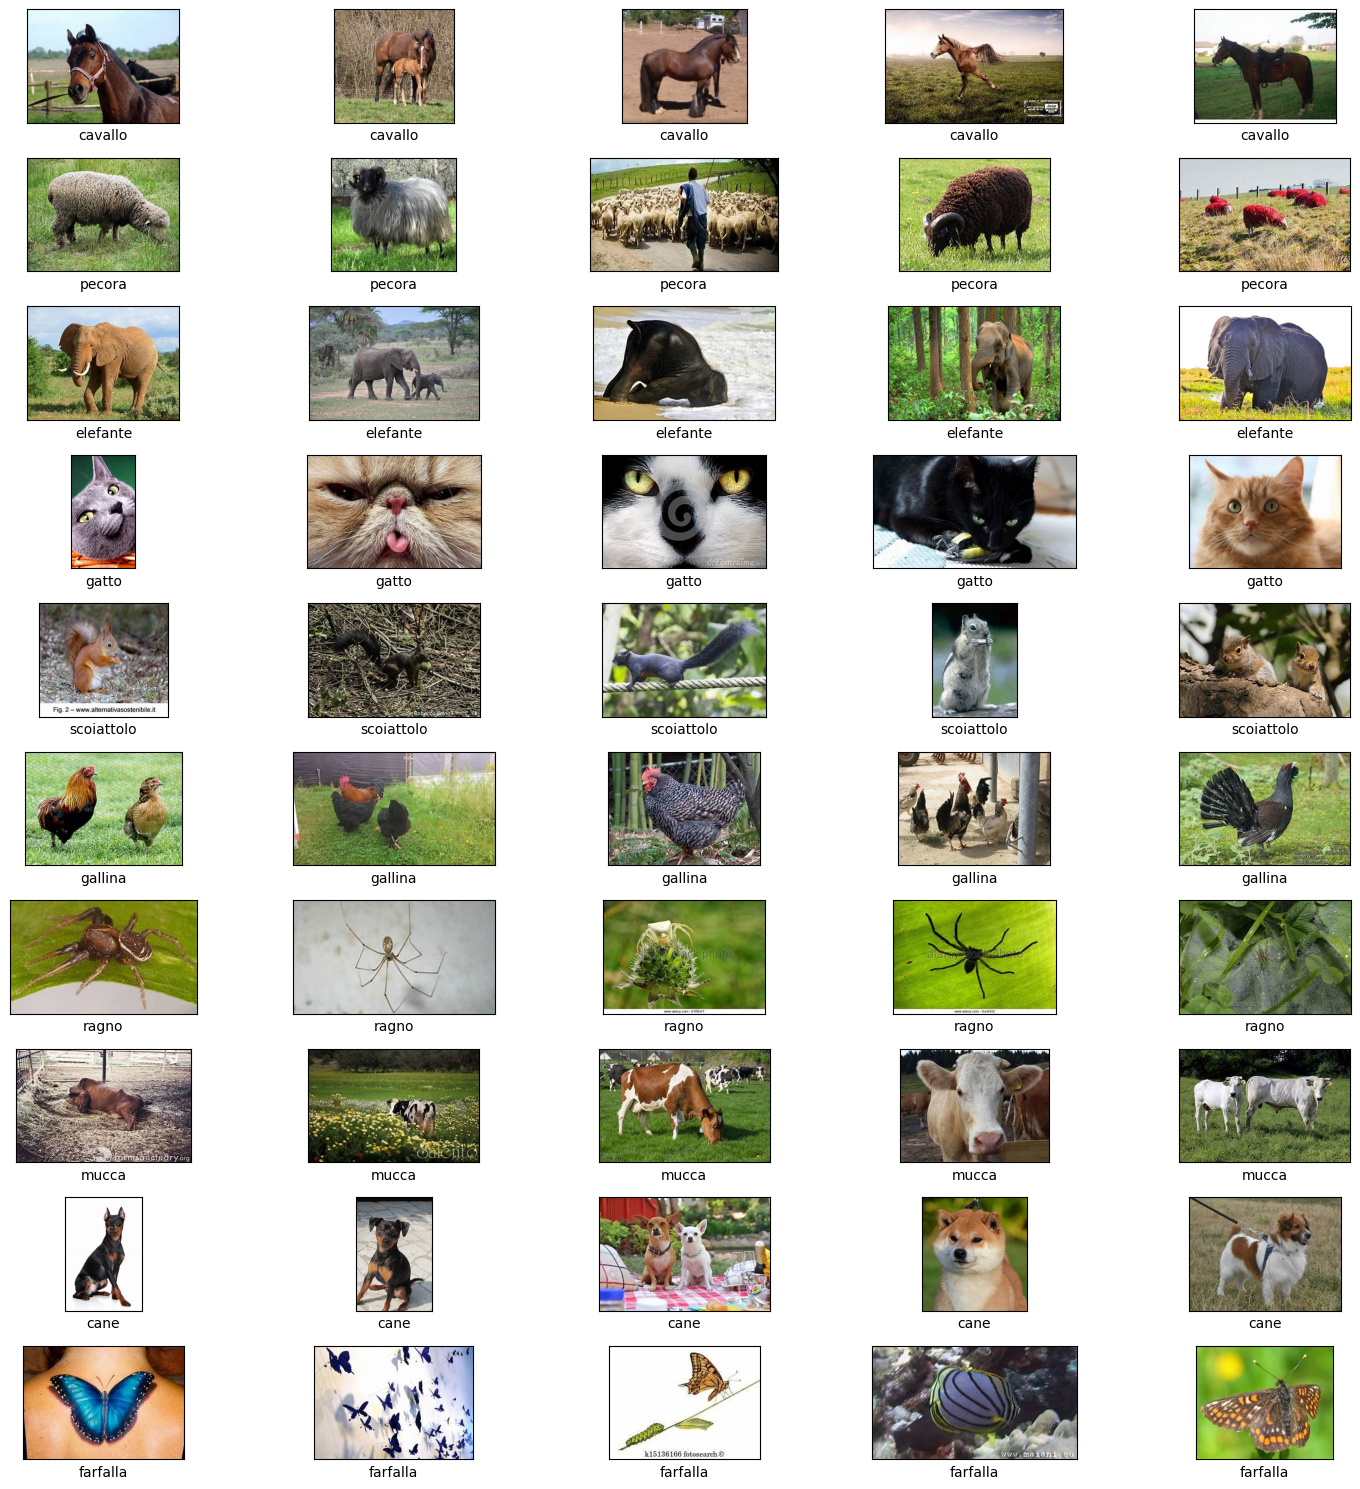

In [13]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
animal_image = {}

# Tentukan path sumber train
path = "/kaggle/input/animals10/"
path_sub = os.path.join(path, "raw-img")
for i in os.listdir(path_sub):
    animal_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "/kaggle/input/animals10/raw-img/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(animal_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

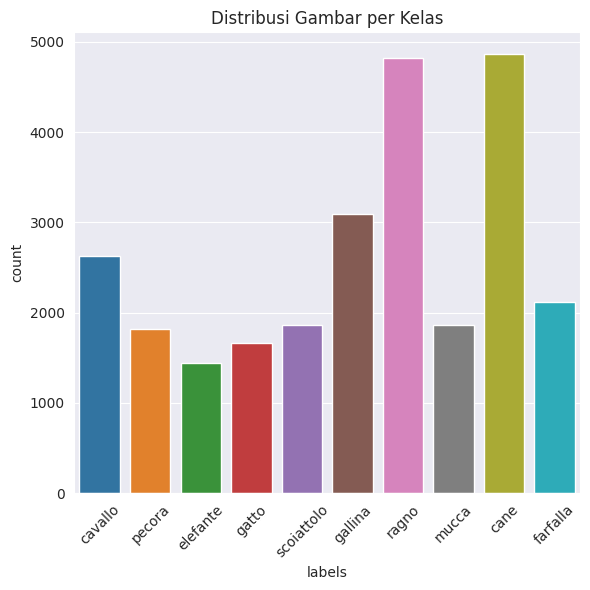

In [14]:
# Definisikan path sumber
animal_path = "/kaggle/input/animals10/raw-img"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(animal_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x="labels", data=distribution_train)
plt.xticks(rotation=45)  # Optional: rotasi label biar gak numpuk
plt.title("Distribusi Gambar per Kelas")
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [15]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(ds_dir, output="splitted_dataset",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 26179 files [02:15, 193.86 files/s]


In [16]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        fill_mode='nearest',
        horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
        'splitted_dataset/train',
        target_size=(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
        shuffle=True, 
        seed=1337
)

Found 20938 images belonging to 10 classes.


In [17]:
validation_datagen = ImageDataGenerator(
        rescale=1./255
        )
validation_generator = validation_datagen.flow_from_directory(
        'splitted_dataset/val',
        target_size=(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
        shuffle=True, 
        seed=1337
)

Found 2614 images belonging to 10 classes.


In [18]:
test_datagen = ImageDataGenerator(
        rescale=1./255
        )

test_generator = test_datagen.flow_from_directory(
        'splitted_dataset/test',
        target_size=(IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="sparse",
        shuffle=True, 
        seed=1337
)

Found 2627 images belonging to 10 classes.


In [19]:
train_generator.class_indices

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

In [20]:
class_names = list(train_generator.class_indices.keys())
class_names

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

Jadi, terdapat 10 kelas pada dataset. Namun, sepertinya label kelas bukan bahasa Inggris, melainkan bahasa spanyol. Saya akan mengubah label kelas menjadi bahasa Indonesia.

## Modelling

In [21]:
mobile_net_base = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                              include_top=False,
                              weights='imagenet')

for layer in mobile_net_base.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
with strategy.scope():
    # Arsitektur model
    model = tf.keras.models.Sequential([
        mobile_net_base,
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )

    # Fit model
    history = model.fit(
        train_generator,
        epochs=28,
        validation_data=validation_generator,
        callbacks=[early_stopping, lr_reduction]
    )


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/28


E0000 00:00:1745199675.342737      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745199679.355661     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745199679.355685     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


655/655 ━━━━━━━━━━━━━━━━━━━━ 245s 354ms/step - accuracy: 0.7372 - loss: 0.8640 - val_accuracy: 0.9120 - val_loss: 0.3529 - learning_rate: 0.0010
Epoch 2/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 229s 346ms/step - accuracy: 0.8733 - loss: 0.4525 - val_accuracy: 0.9090 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 3/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 220s 332ms/step - accuracy: 0.8857 - loss: 0.4076 - val_accuracy: 0.9204 - val_loss: 0.2970 - learning_rate: 0.0010
Epoch 4/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 221s 335ms/step - accuracy: 0.8964 - loss: 0.3493 - val_accuracy: 0.9388 - val_loss: 0.2607 - learning_rate: 0.0010
Epoch 5/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 222s 336ms/step - accuracy: 0.9096 - loss: 0.3201 - val_accuracy: 0.9327 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 6/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 226s 341ms/step - accuracy: 0.9075 - loss: 0.3078 - val_accuracy: 0.9434 - val_loss: 0.2218 - learning_rate: 0.0010
Epoch 7/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 227s 342ms/step - accuracy: 0.9149 

## Evaluasi dan Visualisasi

In [23]:
if early_stopping.stopped_epoch > 0:
    stop_epoch = early_stopping.stopped_epoch - 5
else:
    stop_epoch = len(history.history['loss']) - 1  # Last epoch index

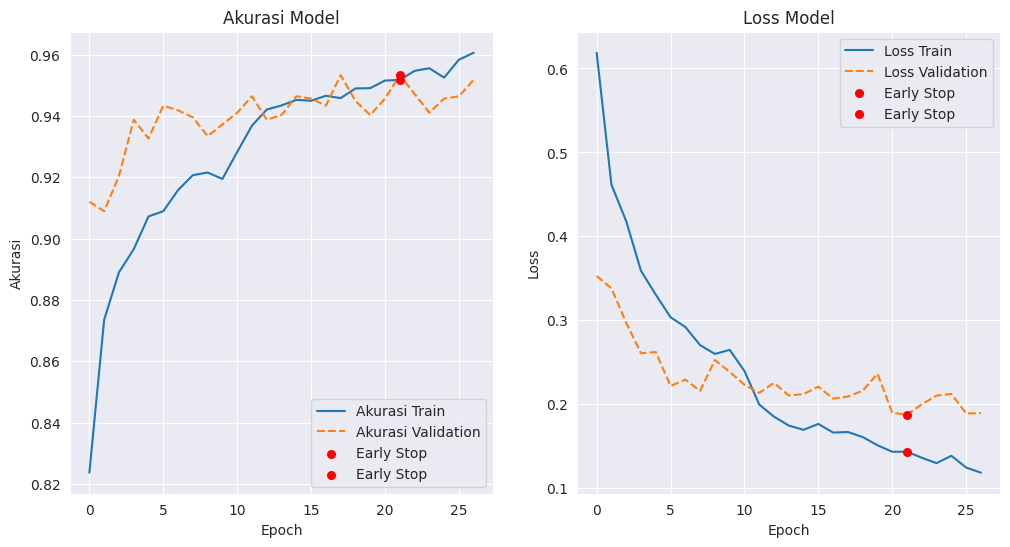

In [24]:
# Create the plots
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Train')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation', linestyle='--')
# Add a red dot at the stopping epoch on the validation accuracy curve
plt.scatter(stop_epoch, history.history['accuracy'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.scatter(stop_epoch, history.history['val_accuracy'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Train')
plt.plot(history.history['val_loss'], label='Loss Validation', linestyle='--')
# Add a red dot at the stopping epoch on the validation loss curve
plt.scatter(stop_epoch, history.history['loss'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.scatter(stop_epoch, history.history['val_loss'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [25]:
plt.savefig('model_evaluation_plot.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [26]:
true_classes = []
predicted_classes = []

for images, labels in test_generator:
    predictions = model.predict(images)
    predicted_classes_batch = np.argmax(predictions, axis=1)

    true_classes.extend(labels)
    predicted_classes.extend(predicted_classes_batch)

    if len(true_classes) >= test_generator.samples:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [27]:
translate = {"cane": "anjing",
             "cavallo": "kuda",
             "elefante": "gajah",
             "farfalla": "kupu-kupu",
             "gallina": "ayam",
             "gatto": "kucing",
             "mucca": "sapi",
             "pecora": "domba",
             "ragno": "laba-laba",
             "scoiattolo": "tupai",
             "anjing": "cane",
             "kuda": "cavallo",
             "gajah" : "elefante",
             "kupu-kupu": "farfalla",
             "ayam": "gallina",
             "kucing": "gatto",
             "sapi": "mucca",
             "domba": "pecora",
             "laba-laba": "ragno",
             "tupai": "scoiattolo"}

In [28]:
#ubah label atau nama kelas pada dataset
original_labels = [label for label, idx in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
translated_labels = [translate.get(label, label) for label in original_labels]

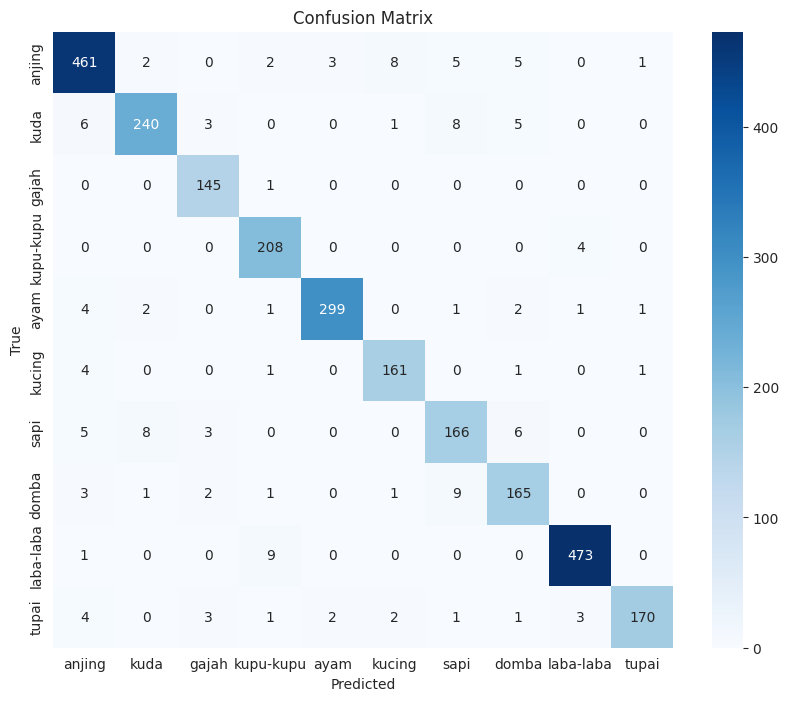

In [29]:
# buat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt_cm = plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=translated_labels, yticklabels=translated_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
plt_cm.savefig('plt_cm.png', dpi=300, bbox_inches='tight')

In [31]:
#mengecek nilai f1-score, recall, precission, support dari hasil test model
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(translated_labels)))

Classification Report:
              precision    recall  f1-score   support

      anjing       0.94      0.95      0.95       487
        kuda       0.95      0.91      0.93       263
       gajah       0.93      0.99      0.96       146
   kupu-kupu       0.93      0.98      0.95       212
        ayam       0.98      0.96      0.97       311
      kucing       0.93      0.96      0.94       168
        sapi       0.87      0.88      0.88       188
       domba       0.89      0.91      0.90       182
   laba-laba       0.98      0.98      0.98       483
       tupai       0.98      0.91      0.94       187

    accuracy                           0.95      2627
   macro avg       0.94      0.94      0.94      2627
weighted avg       0.95      0.95      0.95      2627



In [32]:
# Evaluasi terhadap data latih
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Training Accuracy:", train_accuracy)

# Evaluasi terhadap data uji
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9799407720565796


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 0.9520547986030579


## Konversi Model

In [45]:
model.save("/kaggle/working/saved_model.keras")

In [46]:
model.export('/kaggle/working/saved_model')

Saved artifact at '/kaggle/working/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133798846327568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846329296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846328720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846327184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846327760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846329488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846330448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846330832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846329104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133798846328144: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [49]:
# cek folder
tflite_dir = "/kaggle/working/tflite"
os.makedirs(tflite_dir, exist_ok=True)

# konversi model ke tflite
converter = tf.lite.TFLiteConverter.from_saved_model('/kaggle/working/saved_model')
tflite_model = converter.convert()

# simpan model tflite
tflite_model_path = os.path.join(tflite_dir, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# menyimpan label
class_names = sorted(translated_labels)
with open("/kaggle/working/tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(f"{label}\n")

W0000 00:00:1745208409.016967      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745208409.017006      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [50]:
tfjs_target_dir = "/kaggle/working/tfjs_model"
tfjs.converters.save_keras_model(model, tfjs_target_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
#mengarsipkan folder atau file
!zip -r /kaggle/working//result.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/splitted_dataset/ (stored 0%)
  adding: kaggle/working/splitted_dataset/test/ (stored 0%)
  adding: kaggle/working/splitted_dataset/test/farfalla/ (stored 0%)
  adding: kaggle/working/splitted_dataset/test/farfalla/OIP-_EG1HDWodhRylNWRbJjMaQHaFj.jpeg (deflated 1%)
  adding: kaggle/working/splitted_dataset/test/farfalla/OIP-HPIzBy0hgutcFKL5vU0GowHaFj.jpeg (deflated 1%)
  adding: kaggle/working/splitted_dataset/test/farfalla/OIP-F5Ccxb9KCKv_LPj_ln_REAHaFj.jpeg (deflated 7%)
  adding: kaggle/working/splitted_dataset/test/farfalla/OIP-rGZImnz0oiZaQyPkVcBt0wHaFj.jpeg (deflated 1%)
  adding: kaggle/working/splitted_dataset/test/farfalla/OIP-SFYSy-BOieQx_AWmZpg-bQHaHO.jpeg (deflated 6%)
  adding: kaggle/working/splitted_dataset/test/farfalla/OIP-m2vwlH_HMaLgaiBLpJvTmwHaFj.jpeg (deflated 1%)
  adding: kaggle/working/splitted_dataset/test/farfalla/OIP-sd4lul64lthISEX36BKO2gHaGL.jpeg (deflated 2%)
  adding: kaggle/working/splitted_da

## Inference

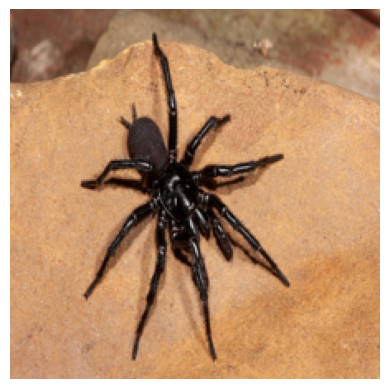

🔍 Label Prediksi: laba-laba
✅ Nilai Confidence: 1.00


In [52]:
from google.colab import files

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/tflite/model.tflite")
interpreter.allocate_tensors()

# Input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
img_size = (224, 224)

# Labels
labels = [
    'anjing',
    'kuda',
    'gajah',
    'kupu-kupu',
    'ayam',
    'kucing',
    'sapi',
    'domba',
    'laba-laba',
    'tupai'
]

# Upload image
image_path = "/kaggle/input/animal10-test/630d9b29535be.jpg"

img = Image.open(image_path).convert('RGB')
img = img.resize(img_size)
input_data = np.expand_dims(img, axis=0).astype(np.float32)
input_data /= 255.0

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]

predicted_index = np.argmax(output_data)
predicted_label = labels[predicted_index]
confidence = output_data[predicted_index]

# Tampilkan hasil prediksi + gambar
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"🔍 Label Prediksi: {predicted_label}")
print(f"✅ Nilai Confidence: {confidence:.2f}")